# 1 - Analyse exploratoire des données

## 1.1 - Importation des bibliothèques

In [1]:
from typing import dataclass_transform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import fonctions as f
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

## 1.2 - Chargement du dataset

In [2]:
dataset_filtered = pd.read_csv('dataset_filtered.csv')

In [3]:
dataset_filtered = dataset_filtered.drop(columns=['TotalGHGEmissions'])

# 2. Modélisations Cible 2

In [4]:
def prepare_data(dataset, target_col='SiteEnergyUse(kBtu)', test_size=0.3, random_state=1221):
    """
    Prépare les données en séparant les variables explicatives et la cible.

    Parameters:
    -----------
    dataset : DataFrame
        Jeu de données complet
    target_col : str, default='TotalGHGEmissions'
        Nom de la colonne cible
    test_size : float, default=0.3
        Proportion des données à utiliser pour le test
    random_state : int, default=1221
        Graine aléatoire pour la reproductibilité

    Returns:
    --------
    X_train, X_test, y_train, y_test : array-like
        Ensembles d'entraînement et de test pour les variables et la cible
    """
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def train_and_evaluate(model, X_train, y_train, X_test, y_test, target_type='brut'):
    """
    Entraîne et évalue un modèle avec gestion cohérente de y.

    Parameters:
    -----------
    model : estimator
        Modèle à entraîner
    X_train, y_train : array-like
        Données d'entraînement
    X_test, y_test : array-like
        Données de test
    target_type : str, default='brut'
        Type de transformation appliquée à la cible ('log' ou 'brut')

    Returns:
    --------
    model : estimator
        Modèle entraîné
    y_pred : array
        Prédictions sur l'ensemble de test
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)
    print_scores(y_test, y_pred, f"Modèle {target_type}")
    return model, y_pred


def build_model(model_type='rf', params=None, grid_search=False, target_transform='brut'):
    """
    Construit un pipeline avec gestion des transformations.

    Parameters:
    -----------
    model_type : str, default='rf'
        Type de modèle à utiliser
    params : dict, default=None
        Paramètres à appliquer au modèle
    grid_search : bool, default=False
        Indique si une recherche par grille doit être effectuée
    target_transform : str, default='brut'
        Type de transformation pour la cible ('log' ou 'brut')

    Returns:
    --------
    pipeline : estimator
        Pipeline de modèle configuré
    """
    # Définition du modèle de base selon le type
    if model_type == 'dummy':
        base_model = DummyRegressor(strategy='mean')
    elif model_type == 'linear':
        base_model = LinearRegression()
    elif model_type == 'ridge':
        base_model = Ridge(random_state=1221)
    elif model_type == 'lasso':
        base_model = Lasso(random_state=1221)
    elif model_type == 'svr':
        base_model = SVR()
    elif model_type == 'rf':
        base_model = RandomForestRegressor(random_state=1221)
    elif model_type == 'xgb':
        base_model = XGBRegressor(random_state=1221)
    elif model_type == 'lgbm':
        base_model = LGBMRegressor(random_state=1221)
    else:
        raise ValueError(f"Type de modèle non reconnu: {model_type}")

    # Application de la transformation logarithmique si demandée
    if target_transform == 'log':
        model = TransformedTargetRegressor(
            regressor=base_model,
            func=np.log1p,
            inverse_func=np.expm1
        )
    else:
        model = base_model

    # Création du pipeline avec standardisation
    pipeline = Pipeline([
        ("preprocessing", StandardScaler()),
        ("modele", model)
    ])

    scoring = {
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'}

    # Application des paramètres ou grid search
    if params:
        if grid_search:
            return GridSearchCV(
                pipeline,
                params,
                cv=5,
                scoring=scoring,
                refit='rmse',
                n_jobs=-1
            )
        else:
            # Configuration des paramètres en fonction du type de modèle et de la transformation
            if target_transform == 'log' and model_type in ['linear', 'ridge', 'lasso', 'svr']:
                pipeline.set_params(**{f"modele__regressor__{k}": v for k, v in params.items()})
            else:
                pipeline.set_params(**{f"{k}": v for k, v in params.items()})

    return pipeline


def print_scores(y_true, y_pred, nom_mod):
    """
    Affiche les métriques avec formatage amélioré

    Parameters:
    -----------
    y_true : array-like
        Valeurs réelles
    y_pred : array-like
        Valeurs prédites
    nom_mod : str
        Nom du modèle pour l'affichage
    """
    quant_75 = np.quantile(y_true, 0.75)
    idx_normal = y_true <= quant_75
    idx_outlier = y_true > quant_75

    print(f"\n=== {nom_mod.upper()} ===")
    print(f"MAE global: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE global: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R2 global: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE normal: {mean_absolute_error(y_true[idx_normal], y_pred[idx_normal]):.2f}")
    print(f"MAE outliers: {mean_absolute_error(y_true[idx_outlier], y_pred[idx_outlier]):.2f}")


def print_scores_cv(model, X, y, cv=5):
    maes = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    rmses = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    r2s = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    print("\n--- Cross-Validation ---")
    print(f"MAE (CV): {maes.mean():.2f} ± {maes.std():.2f}")
    print(f"RMSE (CV): {rmses.mean():.2f} ± {rmses.std():.2f}")
    print(f"R2 (CV): {r2s.mean():.4f} ± {r2s.std():.4f}")

In [5]:
dataset_filtered.head()

,PropertyGFATotal,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,has_energy_star,BuildingAge,SiteEnergyUse(kBtu)
0,88434,1.0,12,88434.0,0.0,60.0,1,89,7226362.5
1,103566,1.0,11,83880.0,15064.0,61.0,1,20,8387933.0
2,61320,1.0,10,61320.0,0.0,56.0,1,90,6794584.0
3,175580,1.0,18,123445.0,68009.0,75.0,1,36,14172606.0
4,83008,1.0,11,81352.0,0.0,27.0,1,90,5758795.0


In [6]:
# Préparation des données
X_train, X_test, y_train, y_test = prepare_data(dataset_filtered)

In [7]:
# 1) Dummy Regressor
model_dummy = build_model(model_type='dummy')

model_dummy.fit(X_train, y_train)
y_pred_dummy = model_dummy.predict(X_test)

print_scores(y_test, y_pred_dummy, "Modèle Dummy (moyenne)")
print_scores_cv(model_dummy, X_train, y_train)

# 2) Linear Regression

model_linear = build_model(model_type='linear')
print_scores_cv(model_linear, X_train, y_train)
trained_linear, pred_linear = train_and_evaluate(model_linear, X_train, y_train, X_test, y_test,target_type="Régression Linéaire")

# 3) Ridge/Lasso

model_ridge = build_model(model_type='ridge')
print_scores_cv(model_ridge, X_train, y_train)
trained_ridge, pred_ridge = train_and_evaluate(model_ridge, X_train, y_train, X_test, y_test, target_type="Ridge")

model_lasso = build_model(model_type='lasso')
print_scores_cv(model_lasso, X_train, y_train)
trained_lasso, pred_lasso = train_and_evaluate(model_lasso, X_train, y_train, X_test, y_test, target_type="Lasso")

# 4) SVR

model_svr = build_model(model_type='svr')
print_scores_cv(model_svr, X_train, y_train)
trained_svr, pred_svr = train_and_evaluate(model_svr, X_train, y_train, X_test, y_test, target_type="SVR")

# 5) Random Forest

# Meilleurs paramètres RF: {'modele__max_depth': 10, 'modele__max_features': None, 'modele__min_samples_leaf': 2, 'modele__n_estimators': 500}

params_rf = {
    "modele__n_estimators": [500],
    "modele__max_depth": [10],
    "modele__min_samples_leaf": [2],
    "modele__max_features": [None]
}

model_rf = build_model(model_type='rf', params=params_rf, grid_search=True)
trained_rf, pred_rf = train_and_evaluate(model_rf, X_train, y_train, X_test, y_test, target_type="Random Forest")

for score in ['rmse', 'mae', 'r2']:
    arr = trained_rf.cv_results_[f"mean_test_{score}"]
    arr_std = trained_rf.cv_results_[f"std_test_{score}"]
    best_idx = trained_rf.best_index_
    best_mean = abs(arr[best_idx]) if score != 'r2' else arr[best_idx]
    print(f"{score.upper()} (CV): {best_mean:.3f} ± {arr_std[best_idx]:.3f}")

# 6) XGBoost

# Meilleurs paramètres XGB: {'modele__colsample_bytree': 1, 'modele__learning_rate': 0.01, 'modele__max_depth': 4, 'modele__n_estimators': 500, 'modele__reg_alpha': 0.1, 'modele__reg_lambda': 1, 'modele__subsample': 0.6}

params_xgb = {
    'modele__n_estimators': [500],
    'modele__max_depth': [4],
    'modele__learning_rate': [0.01],
    'modele__subsample': [0.6],
    'modele__colsample_bytree': [1],
    'modele__reg_alpha': [0.1],
    'modele__reg_lambda': [1],
}

model_xgb = build_model(model_type='xgb', params=params_xgb, grid_search=True)
trained_xgb, pred_xgb = train_and_evaluate(model_xgb, X_train, y_train, X_test, y_test, target_type="XGBoost")

for score in ['rmse', 'mae', 'r2']:
    arr = trained_xgb.cv_results_[f"mean_test_{score}"]
    arr_std = trained_xgb.cv_results_[f"std_test_{score}"]
    best_idx = trained_xgb.best_index_
    best_mean = abs(arr[best_idx]) if score != 'r2' else arr[best_idx]
    print(f"{score.upper()} (CV): {best_mean:.3f} ± {arr_std[best_idx]:.3f}")


=== MODÈLE DUMMY (MOYENNE) ===
MAE global: 5424221.31
RMSE global: 8411358.78
R2 global: -0.0004
MAE normal: 3745372.33
MAE outliers: 10460768.26

--- Cross-Validation ---
MAE (CV): 5559185.61 ± 579263.52
RMSE (CV): 9200940.80 ± 2136896.44
R2 (CV): -0.0184 ± 0.0179

--- Cross-Validation ---
MAE (CV): 2976204.21 ± 508290.91
RMSE (CV): 5531048.48 ± 1738165.93
R2 (CV): 0.6423 ± 0.0652

=== MODÈLE RÉGRESSION LINÉAIRE ===
MAE global: 2835807.94
RMSE global: 4742043.73
R2 global: 0.6820
MAE normal: 1883198.90
MAE outliers: 5693635.05

--- Cross-Validation ---
MAE (CV): 2975165.29 ± 507926.95
RMSE (CV): 5527861.21 ± 1737168.79
R2 (CV): 0.6427 ± 0.0650

=== MODÈLE RIDGE ===
MAE global: 2834852.77
RMSE global: 4741193.43
R2 global: 0.6821
MAE normal: 1882602.04
MAE outliers: 5691604.96

--- Cross-Validation ---
MAE (CV): 2976203.92 ± 508290.82
RMSE (CV): 5531048.82 ± 1738165.79
R2 (CV): 0.6423 ± 0.0652

=== MODÈLE LASSO ===
MAE global: 2835807.70
RMSE global: 4742043.56
R2 global: 0.6820
MAE n

| Modèle           | RMSE global (CV ± σ)           | MAE global (CV ± σ)           | R² global (CV ± σ)           |
|------------------|-------------------------------|-------------------------------|------------------------------|
| Dummy            | 8 411 359 (9 200 941 ± 2 136 896)   | 5 424 221 (5 559 186 ± 579 264) | -0.0004 (-0.0184 ± 0.0179)   |
| Régression Linéaire | 4 742 044 (5 527 861 ± 1 737 169) | 2 835 808 (2 975 165 ± 507 927) | 0.6820 (0.6427 ± 0.0650)     |
| Ridge            | 4 741 193 (5 531 049 ± 1 738 166)    | 2 834 853 (2 976 204 ± 508 291) | 0.6821 (0.6423 ± 0.0652)     |
| Lasso            | 4 742 044 (9 725 876 ± 2 324 355)    | 2 835 808 (4 623 139 ± 858 075) | 0.6820 (-0.1334 ± 0.0255)    |
| SVR              | 8 980 966                         | 4 514 358                         | -0.1405                      |
| Random Forest    | 4 794 595 (5 470 916 ± 1 647 955)    | 2 595 999 (2 818 703 ± 599 314) | 0.6749 (0.642 ± 0.073)       |
| XGBoost          | 4 759 470 (5 631 155 ± 1 703 023)    | 2 674 225 (2 832 193 ± 620 758) | 0.6797 (0.623 ± 0.078)       |


In [8]:
X = dataset_filtered.drop(columns=['SiteEnergyUse(kBtu)'])

In [9]:
best_pipeline = model_xgb.best_estimator_
modele_step = best_pipeline.named_steps["modele"]

if hasattr(modele_step, 'regressor_'):  # Cas TransformedTargetRegressor
    base_model = modele_step.regressor_
else:
    base_model = modele_step

importances = base_model.feature_importances_

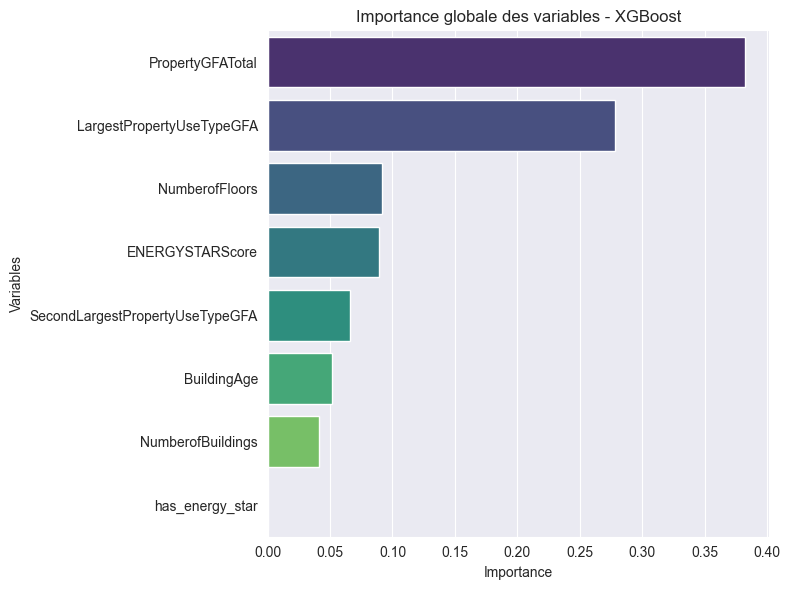

In [10]:
importances = base_model.feature_importances_
# Ici, X_train est celui fourni lors de l'entraînement, avec les bonnes colonnes/features
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
importances_df = importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=importances_df.head(15), y="feature", x="importance", palette="viridis", hue="feature", legend=False)
plt.title("Importance globale des variables - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

C:\Users\Thomas\miniconda3\envs\Data_Science\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


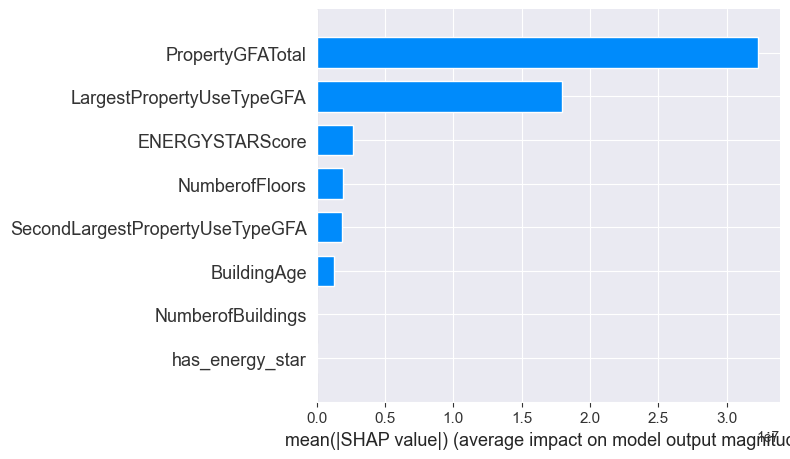

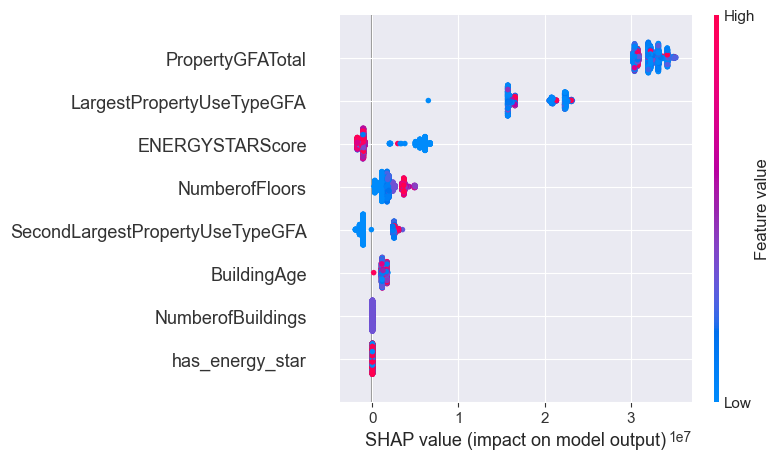

In [11]:
import shap

explainer = shap.Explainer(base_model)
shap_values = explainer(X_train)

# Summary plot (global)
shap.summary_plot(shap_values, X_train, plot_type="bar")
# Beeswarm plot (global/local mix)
shap.summary_plot(shap_values, X_train)
# Force plot (local, première observation par exemple)
shap.plots.force(shap_values[0])

### Analyse de l’importance des variables (feature importance)

Après optimisation du modèle XGBoost, nous avons analysé l’importance des variables explicatives à l’aide de la méthode **SHAP** et de l’attribut `feature_importances_`.

- **`PropertyGFATotal`** ressort très nettement comme la variable la plus déterminante pour la prédiction de la consommation énergétique (**SiteEnergyUse(kBtu)**). Cela s’explique logiquement par le fait que la consommation d’énergie est étroitement liée à la surface totale des bâtiments: plus un bâtiment est grand, plus son usage énergétique potentiel est élevé.
- **`LargestPropertyUseTypeGFA`** arrive ensuite, confirmant que la surface dédiée à l’activité principale influence significativement la quantité totale d'énergie consommée.
- Des variables comme **`ENERGYSTARScore`**, **`NumberOfFloors`**, **`SecondLargestPropertyUseGFA`** et **`BuildingAge`** ont un impact moindre.
- Enfin, l’influence de **`NumberOfBuildings`** et **`has_energy_star`** demeure très marginale dans ce contexte, ce qui montre que le modèle s’appuie principalement sur la taille, l’utilisation et l’intensité carbone/énergétique du bâtiment.

Sur le plan métier, ces résultats apparaissent cohérents: la taille totale et les usages concentrés expliquent la majeure partie de la consommation énergétique. D’autres facteurs, comme le score environnemental ou l’âge du bâtiment, affinent de façon secondaire les prédictions.

Pour illustrer ces résultats, nous proposons :
- Un **diagramme en barres** mettant en avant les variables les plus influentes
- Un **SHAP summary plot** affichant à la fois l’importance globale et l’influence positive/négative de chaque variable sur la prédiction.

### Benchmark

In [12]:
import time
import numpy as np

N_SAMPLES = 100
X_sample = X_test.sample(N_SAMPLES, random_state=42)

start = time.time()
y_pred = best_pipeline.predict(X_sample)
elapsed = time.time() - start

print(f"Temps total pour {N_SAMPLES} prédictions : {elapsed*1000:.2f} ms")
print(f"Temps moyen par prédiction : {elapsed/N_SAMPLES*1000:.4f} ms")
print(f"Vitesse d'inférence : {N_SAMPLES/(elapsed):.2f} prédictions/seconde")

Temps total pour 100 prédictions : 2.00 ms
Temps moyen par prédiction : 0.0200 ms
Vitesse d'inférence : 50003.62 prédictions/seconde


### Impact de energystarscore

In [13]:
X = dataset_filtered.drop(columns=['SiteEnergyUse(kBtu)', 'ENERGYSTARScore', 'has_energy_star'])
y = dataset_filtered['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1221
)

In [14]:
# 6) XGBoost

# Meilleurs paramètres XGB: {'modele__colsample_bytree': 1, 'modele__learning_rate': 0.01, 'modele__max_depth': 4, 'modele__n_estimators': 500, 'modele__reg_alpha': 0.1, 'modele__reg_lambda': 1, 'modele__subsample': 0.6}

params_xgb = {
    'modele__n_estimators': [500],
    'modele__max_depth': [4],
    'modele__learning_rate': [0.01],
    'modele__subsample': [0.6],
    'modele__colsample_bytree': [1],
    'modele__reg_alpha': [0.1],
    'modele__reg_lambda': [1],
}

model_xgb = build_model(model_type='xgb', params=params_xgb, grid_search=True)
trained_xgb, pred_xgb = train_and_evaluate(model_xgb, X_train, y_train, X_test, y_test, target_type="XGBoost")

for score in ['rmse', 'mae', 'r2']:
    arr = trained_xgb.cv_results_[f"mean_test_{score}"]
    arr_std = trained_xgb.cv_results_[f"std_test_{score}"]
    best_idx = trained_xgb.best_index_
    best_mean = abs(arr[best_idx]) if score != 'r2' else arr[best_idx]
    print(f"{score.upper()} (CV): {best_mean:.3f} ± {arr_std[best_idx]:.3f}")


=== MODÈLE XGBOOST ===
MAE global: 3027779.88
RMSE global: 5417473.16
R2 global: 0.5850
MAE normal: 1849162.92
MAE outliers: 6563630.78
RMSE (CV): 5857228.978 ± 1840784.896
MAE (CV): 3103749.323 ± 685830.753
R2 (CV): 0.596 ± 0.073


## Analyse de l’influence de la variable `EnergyStarScore`

Dans le cadre de l’analyse d’importance des variables, une **expérience d’ablation** a été réalisée: le modèle XGBoost a été entraîné une première fois **avec** la variable `EnergyStarScore`, puis une seconde fois **sans**, afin d’évaluer concrètement son impact sur la prédiction de la consommation d'énergie.

|                                   | **Sans `EnergyStarScore`**          | **Avec `EnergyStarScore`**         |
|-----------------------------------|:-----------------------------------:|:----------------------------------:|
| **MAE global**                    | 3027779.88                        | 2674225.38                       |
| **RMSE global**                   | 5417473.16                        | 4759470.27                       |
| **R² global**                     | 0.5850                              | 0.6797                             |
| **MAE normal**                    | 1849162.92                        | 1684127.22                       |
| **MAE outliers**                  | 6563630.78                        | 5644519.85                       |
| **RMSE (CV)**                     | 5857228.98 ± 1840784.90         | 5631154.65 ± 1703023.47        |
| **MAE (CV)**                      | 3103749.32 ± 685830.75           | 2832193.29 ± 620757.86          |
| **R² (CV)**                       | 0.596 ± 0.073                       | 0.623 ± 0.078                      |

**Interprétation:**

- Les différences de performances sont **notables**: la suppression d’`EnergyStarScore` entraîne une dégradation de toutes les métriques (MAE, RMSE, R²), aussi bien sur les données globales qu'en validation croisée.
- Le modèle XGBoost reste performant sans cette variable, mais sa présence améliore de façon perceptible la précision des prédictions (baisse significative du MAE et du RMSE, augmentation du R²).
- L’apport d’`EnergyStarScore` dans ce cas ne se limite donc pas à un effet marginal: sa suppression réduit notablement la performance du modèle.

**Conclusion:**

> Contrairement à la prédiction des émissions de gaz à effet de serre, la variable `EnergyStarScore` joue ici un rôle important dans la prédiction de la consommation d’énergie. Il est donc recommandé de la conserver dans le modèle pour garantir une meilleure précision.

## Conclusion

L’évaluation des différents modèles montre que **Random Forest** et **XGBoost** offrent la meilleure précision pour prédire la consommation d’énergie des bâtiments (**R² ≈ 0,62–0,68** en validation croisée). L’analyse d’importance des variables indique que des facteurs comme **la taille du bâtiment**, **l’année de construction** et le **score Energy Star** jouent un rôle significatif.

Contrairement à ce qui a été observé pour la prédiction des émissions de gaz à effet de serre, la suppression de la variable `EnergyStarScore` entraîne une baisse notable des performances des modèles sur cette cible. Il est donc recommandé de conserver `EnergyStarScore` dans le modèle pour garantir une meilleure précision et une meilleure robustesse des prédictions.